# Jo(h)ns of the U.S. House of Representatives
This visualization was inspired by this tweet:

<blockquote class="twitter-tweet"><p lang="en" dir="ltr">When Fetterman takes office in January, 10% of all U.S. senators will be named John/Jon</p>&mdash; Grace Segers (@Grace_Segers) <a href="https://twitter.com/Grace_Segers/status/1590432772812079104?ref_src=twsrc%5Etfw">November 9, 2022</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>

I wanted to find out who the current Jo(h)ns are, who they represent, and some other information about them. To do this, I pulled data from the wikipedia page on current US senators:
* Source: https://en.wikipedia.org/wiki/List_of_current_United_States_senators

If you're curious, there's also a notebook running this same analysis on the Senate in the same folder.

In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
import datetime as dt
import numpy as np
import seaborn as sns

In [2]:
# House of Reps
table_data = {
    'url': "https://en.wikipedia.org/wiki/List_of_current_members_of_the_United_States_House_of_Representatives",
    'attrs': {'class': 'wikitable',
              'id': 'votingmembers'}
}

In [3]:
# get the response in the form of html
wikiurl=table_data['url']
table_class="wikitable sortable jquery-tablesorter"
response=requests.get(wikiurl)
print(response.status_code)

200


In [4]:
# parse data from the html into a beautifulsoup object
soup = BeautifulSoup(response.text, 'html.parser')
rep_tbl=soup.find('table', table_data['attrs'])

In [5]:
df=pd.read_html(str(rep_tbl))
# convert list to dataframe
df=pd.DataFrame(df[0])

Lets take a look at what this data looks like...

In [6]:
df.head(2)

,District,Member,Party,Party.1,Prior experience,Education,Assumed office,Residence,Born[2]
0,Alabama 1,Jerry Carl,NaN,Republican,Mobile County Commission,Florida Gateway College,2021,Mobile,(age 64)
1,Alabama 2,Barry Moore,NaN,Republican,Alabama House of Representatives,Enterprise State Community College (AS)Auburn ...,2021,Enterprise,(age 56)


Clearly need to do some work and format some columns

In [7]:
# Drop seemingly empty columns
df.columns = [re.sub(r'\[[a-zA-Z0-9]+\]','', d) for d in df.columns]
df_processed = df[['District', 'Member', 'Party.1', 'Assumed office', 'Born']] \
                 .rename(columns={'Party.1': 'Party'}) \
                 .replace({r'\[[a-zA-Z]+\]':'',
                           r'\(DFL\)': '',
                           r' \(special\)': '', # Special election
                           'VACANT': np.nan},   # Some seats may be empty
                          regex=True)
df_processed['Assumed office'] = pd.to_datetime(df_processed['Assumed office'],
                                                format='%B %d, %Y',
                                                errors='ignore')
df_processed.head(3)

,District,Member,Party,Assumed office,Born
0,Alabama 1,Jerry Carl,Republican,2021,(age 64)
1,Alabama 2,Barry Moore,Republican,2021,(age 56)
2,Alabama 3,Mike Rogers,Republican,2003,(age 64)


We need to properly break out the state

In [8]:
# Separate the state from the district #
df_processed['State'] = [' '.join(district.split()[:-1]) for district in df_processed['District']]
df_processed.head(2)

,District,Member,Party,Assumed office,Born,State
0,Alabama 1,Jerry Carl,Republican,2021,(age 64),Alabama
1,Alabama 2,Barry Moore,Republican,2021,(age 56),Alabama


Just for fun let's break down how long senators have been serving by number of years

In [9]:
# Get their age
rows = (~pd.isna(df_processed['Born']))     # Figure out which Born rows are not null
df_processed.loc[rows,'age'] = df_processed.loc[rows,'Born'] \
                                           .map(lambda x: int(re.search(r'\(age\s([0-9]{2})\)', x)
                                                                .group(1)))
df_processed.head(2)

,District,Member,Party,Assumed office,Born,State,age
0,Alabama 1,Jerry Carl,Republican,2021,(age 64),Alabama,64.0
1,Alabama 2,Barry Moore,Republican,2021,(age 56),Alabama,56.0


In [10]:
# Compute delta-years
rows = ~pd.isna(df_processed['Assumed office'])
df_processed.loc[rows,'Assumed office'] = [int(year) for year in df_processed.loc[rows,'Assumed office']]
df_processed['Years in Office'] = (dt.datetime.now().year - df_processed['Assumed office'])
df_processed.sort_values('Years in Office', ascending=False)

,District,Member,Party,Assumed office,Born,State,age,Years in Office
185,Maryland 5,Steny Hoyer,Democratic,1981,(age 83),Maryland,83.0,41
171,Kentucky 5,Hal Rogers,Republican,1981,(age 84),Kentucky,84.0,41
245,New Jersey 4,Chris Smith,Republican,1981,(age 69),New Jersey,69.0,41
306,Ohio 9,Marcy Kaptur,Democratic,1983,(age 76),Ohio,76.0,39
203,Michigan 6,Fred Upton,Republican,1987,(age 69),Michigan,69.0,35
...,...,...,...,...,...,...,...,...
7,Alaska at-large,Mary Peltola,Democratic,2022,(age 49),Alaska,49.0,0
212,Minnesota 1,Brad Finstad,Republican,2022,(age 46),Minnesota,46.0,0
99,Florida 13,NaN,NaN,NaN,NaN,Florida,NaN,NaN
108,Florida 22,NaN,NaN,NaN,NaN,Florida,NaN,NaN


[Text(0.5, 1.0, 'House Reps by Years in Office')]

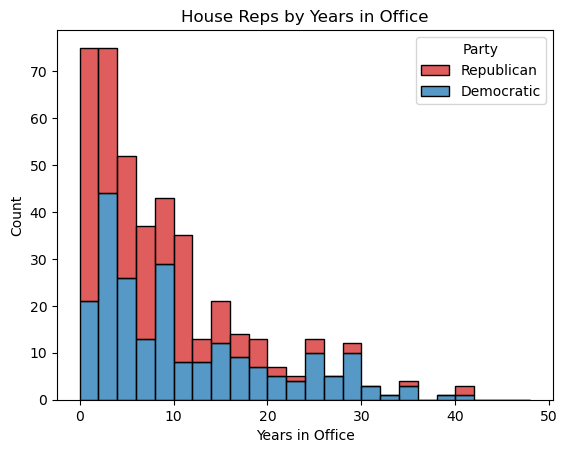

In [11]:
# Plot it up!
sns.histplot(data=df_processed, 
             x="Years in Office", 
             hue='Party',
             multiple='stack',
             bins = range(0,50,2),
             palette={
                'Republican': 'tab:red',
                'Democratic': 'tab:blue',
                'Independent': 'tab:green'
             }) \
   .set(title='House Reps by Years in Office')

In [12]:
# 5 longest serving representatives:
df_processed.sort_values('Years in Office', ascending=False).iloc[:5]

,District,Member,Party,Assumed office,Born,State,age,Years in Office
185,Maryland 5,Steny Hoyer,Democratic,1981,(age 83),Maryland,83.0,41
171,Kentucky 5,Hal Rogers,Republican,1981,(age 84),Kentucky,84.0,41
245,New Jersey 4,Chris Smith,Republican,1981,(age 69),New Jersey,69.0,41
306,Ohio 9,Marcy Kaptur,Democratic,1983,(age 76),Ohio,76.0,39
203,Michigan 6,Fred Upton,Republican,1987,(age 69),Michigan,69.0,35


OK, let's do what we came here to do

In [13]:
match_str = r'(Jon|John)'
df_processed.loc[rows,'is match'] = df_processed.loc[rows,'Member'] \
                                                .map(lambda x: re.match(match_str, x) is not None,
                                                     na_action='ignore')
print(df_processed[df_processed['is match'] & ~pd.isna(df_processed['is match'])].shape[0])                                                  
df_processed[df_processed['is match'] & ~pd.isna(df_processed['is match'])]

11


,District,Member,Party,Assumed office,Born,State,age,Years in Office,is match
23,California 3,John Garamendi,Democratic,2009,(age 77),California,77.0,13,True
81,Connecticut 1,John B. Larson,Democratic,1999,(age 74),Connecticut,74.0,23,True
90,Florida 4,John Rutherford,Republican,2017,(age 70),Florida,70.0,5,True
169,Kentucky 3,John Yarmuth,Democratic,2007,(age 75),Kentucky,75.0,15,True
183,Maryland 3,John Sarbanes,Democratic,2007,(age 60),Maryland,60.0,15,True
201,Michigan 4,John Moolenaar,Republican,2015,(age 61),Michigan,61.0,7,True
280,New York 24,John Katko,Republican,2015,(age 60),New York,60.0,7,True
336,Pennsylvania 13,John Joyce,Republican,2019,(age 65),Pennsylvania,65.0,3,True
357,Tennessee 6,John Rose,Republican,2019,(age 57),Tennessee,57.0,3,True
391,Texas 31,John Carter,Republican,2003,(age 81),Texas,81.0,19,True


[Text(0.5, 1.0, 'Johns in the House by Years in Office')]

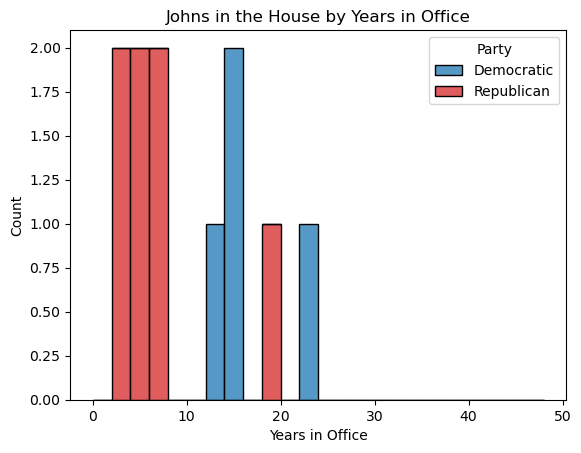

In [14]:
sns.histplot(data=df_processed.loc[(~pd.isna(df_processed['is match'])) &
                                   (df_processed['is match'])], 
             x="Years in Office", 
             hue='Party',
             multiple='stack',
             bins = range(0,50,2),
             palette={
                'Republican': 'tab:red',
                'Democratic': 'tab:blue',
                'Independent': 'tab:green'
             }) \
   .set(title='Johns in the House by Years in Office')

[Text(0.5, 1.0, 'Johns in the House of Reps by Age')]

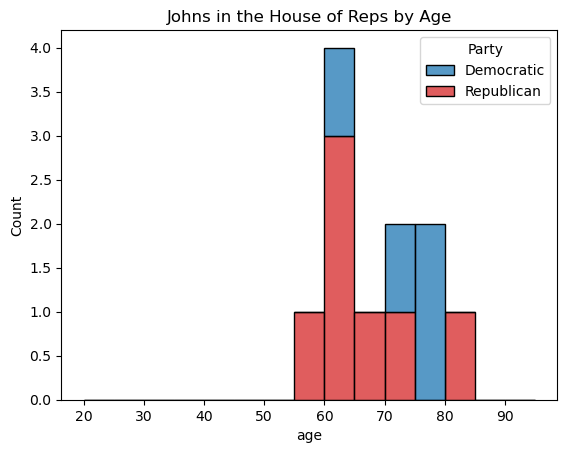

In [15]:
# How old are the Jo(h)n(i)s?
sns.histplot(data=df_processed.loc[(~pd.isna(df_processed['is match'])) &
                                   (df_processed['is match'])], 
             x="age", 
             hue='Party',
             multiple='stack',
             bins = range(20,100,5),
             palette={
                'Republican': 'tab:red',
                'Democratic': 'tab:blue',
                'Independent': 'tab:green'
             }) \
   .set(title='Johns in the House of Reps by Age')

In [16]:
# Join the postal abbreviation to the actual state names
postal = pd.read_csv('../../data/state_abbrv.csv', usecols=[0,1])
df_processed = df_processed.merge(postal, left_on='State', right_on='US STATE')

In [17]:
plt_data = df_processed.loc[(~pd.isna(df_processed['is match'])) &
                            (df_processed['is match'])]

# Build the choropleth
import plotly.express as px
fig = px.choropleth(plt_data, 
    locations=plt_data['POSTAL ABBREVIATION'], 
    locationmode='USA-states',
    color=plt_data['is match'],
    scope="usa",
    labels={'is match':'Has a Jo(h)n',
            'POSTAL ABBREVIATION':'State'},
    title='Jo(h)ns in the U.S. House of Representatives'
)
fig.update_layout(margin={"r":0,"t":40,"l":0,"b":0})

fig.show()

## But Maybe...
But maybe we're being a little presumptuous. Is there another first name that appears more frequently in the house?

In [18]:
df_processed

,District,Member,Party,Assumed office,Born,State,age,Years in Office,is match,US STATE,POSTAL ABBREVIATION
0,Alabama 1,Jerry Carl,Republican,2021,(age 64),Alabama,64.0,1,False,Alabama,AL
1,Alabama 2,Barry Moore,Republican,2021,(age 56),Alabama,56.0,1,False,Alabama,AL
2,Alabama 3,Mike Rogers,Republican,2003,(age 64),Alabama,64.0,19,False,Alabama,AL
3,Alabama 4,Robert Aderholt,Republican,1997,(age 57),Alabama,57.0,25,False,Alabama,AL
4,Alabama 5,Mo Brooks,Republican,2011,(age 68),Alabama,68.0,11,False,Alabama,AL
...,...,...,...,...,...,...,...,...,...,...,...
430,Wisconsin 5,Scott Fitzgerald,Republican,2021,(age 58),Wisconsin,58.0,1,False,Wisconsin,WI
431,Wisconsin 6,Glenn Grothman,Republican,2015,(age 67),Wisconsin,67.0,7,False,Wisconsin,WI
432,Wisconsin 7,Tom Tiffany,Republican,2020,(age 64),Wisconsin,64.0,2,False,Wisconsin,WI
433,Wisconsin 8,Mike Gallagher,Republican,2017,(age 38),Wisconsin,38.0,5,False,Wisconsin,WI


In [19]:
# Get the first names of the representatives
rows = ~pd.isna(df_processed['Member'])
df_processed.loc[rows,'First Name'] = df_processed.loc[rows,'Member'].str \
                                         .split(' ') \
                                         .map(lambda x: x[0])
df_processed.loc[pd.isna(df_processed['First Name'])]

,District,Member,Party,Assumed office,Born,State,age,Years in Office,is match,US STATE,POSTAL ABBREVIATION,First Name
99,Florida 13,NaN,NaN,NaN,NaN,Florida,NaN,NaN,NaN,Florida,FL,NaN
108,Florida 22,NaN,NaN,NaN,NaN,Florida,NaN,NaN,NaN,Florida,FL,NaN
151,Indiana 2,NaN,NaN,NaN,NaN,Indiana,NaN,NaN,NaN,Indiana,IN,NaN


In [20]:
fn_count = df_processed.groupby('First Name') \
                       .agg({'First Name': 'count'}) \
                       .rename(columns={'First Name': 'count'}) \
                       .sort_values('count', ascending=False) \
                       .reset_index()
fn_count

,First Name,count
0,Mike,14
1,John,11
2,David,10
3,Jim,8
4,Tom,7
...,...,...
268,Gwen,1
269,Hakeem,1
270,Hal,1
271,Haley,1


So 'John' actually gets beatten out by 'Mike' by 3 representatives! You know what that means: we need to go back and redo the analysis now, but check for 'Mike/Michael' pairs, as well as the 'David/Dave' combination for completeness

In [21]:
# Jon/John
fn_count[[re.match(r'(Jon|John)', x) is not None for x in fn_count['First Name']]]

,First Name,count
1,John,11


In [22]:
# Mike/Michael/Michelle/Michele
fn_count[[re.match(r'(Mike|Mich[ae])', x) is not None for x in fn_count['First Name']]]

,First Name,count
0,Mike,14
9,Michael,5
69,Michelle,2


In [23]:
# David/Dave
fn_count[[re.match(r'(Dav)', x) is not None for x in fn_count['First Name']]]

,First Name,count
2,David,10


In [24]:
# Jim/James
fn_count[[re.match(r'(Jim|James)', x) is not None for x in fn_count['First Name']]]

,First Name,count
3,Jim,8
38,Jimmy,2
47,James,2


So to summarize, we have TWO name groups that are more common than 'John':

1. Mike/Michael/Michelle: 19
1. Jim/Jimmy/James: 12
1. John: 11
1. David: 10

I'm going to call this the 'Mikey' contingent :). Also, in case you're curious, there's no Michelle. Let's go ahead and generate the relevant plots for the Mikey contingent.

In [25]:
# Get the data on the Mikey contingent
match_str = r'(Mike|Mich[ae])'
df_processed.loc[rows,'is match'] = df_processed.loc[rows,'Member'] \
                                                .map(lambda x: re.match(match_str, x) is not None,
                                                     na_action='ignore') \
                                                .drop(columns='Born')
print(df_processed[df_processed['is match'] & ~pd.isna(df_processed['is match'])].shape[0])                                                  
plt_data = df_processed[df_processed['is match'] & ~pd.isna(df_processed['is match'])]
plt_data

21


,District,Member,Party,Assumed office,Born,State,age,Years in Office,is match,US STATE,POSTAL ABBREVIATION,First Name
2,Alabama 3,Mike Rogers,Republican,2003,(age 64),Alabama,64.0,19,True,Alabama,AL,Mike
25,California 5,Mike Thompson,Democratic,1999,(age 71),California,71.0,23,True,California,CA,Mike
45,California 25,Mike Garcia,Republican,2020,(age 46),California,46.0,2,True,California,CA,Mike
68,California 48,Michelle Steel,Republican,2021,(age 67),California,67.0,1,True,California,CA,Michelle
69,California 49,Mike Levin,Democratic,2019,(age 44),California,44.0,3,True,California,CA,Mike
92,Florida 6,Michael Waltz,Republican,2019,(age 48),Florida,48.0,3,True,Florida,FL,Michael
131,Idaho 2,Mike Simpson,Republican,1999,(age 72),Idaho,72.0,23,True,Idaho,ID,Mike
136,Illinois 5,Mike Quigley,Democratic,2009,(age 64),Illinois,64.0,13,True,Illinois,IL,Mike
143,Illinois 12,Mike Bost,Republican,2015,(age 61),Illinois,61.0,7,True,Illinois,IL,Mike
176,Louisiana 4,Mike Johnson,Republican,2017,(age 50),Louisiana,50.0,5,True,Louisiana,LA,Mike


[Text(0.5, 1.0, 'Mikeys in the House by Years in Office')]

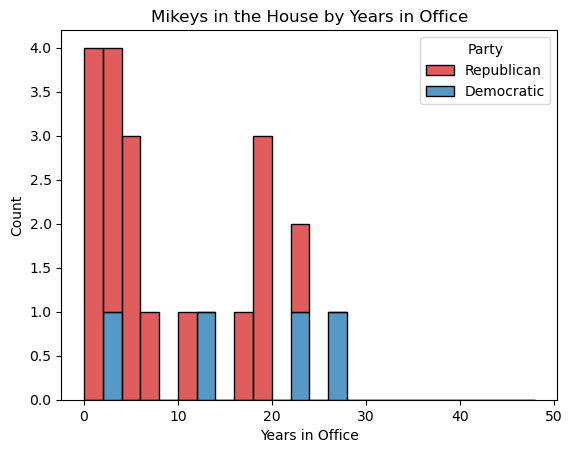

In [26]:
sns.histplot(data=plt_data, 
             x="Years in Office", 
             hue='Party',
             multiple='stack',
             bins = range(0,50,2),
             palette={
                'Republican': 'tab:red',
                'Democratic': 'tab:blue',
                'Independent': 'tab:green'
             }) \
   .set(title='Mikeys in the House by Years in Office')

Very Republican lean to the Mikey contingent.

[Text(0.5, 1.0, 'Mikeys in the House of Reps by Age')]

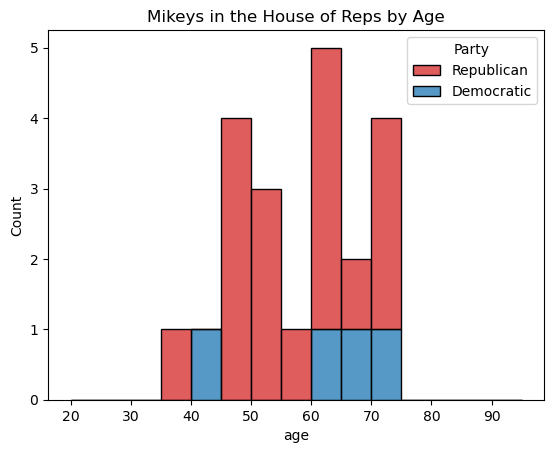

In [27]:
# How old are the Mikeys?
sns.histplot(data=plt_data, 
             x="age", 
             hue='Party',
            #  kde=True,
             multiple='stack',
             bins = range(20,100,5),
             palette={
                'Republican': 'tab:red',
                'Democratic': 'tab:blue',
                'Independent': 'tab:green'
             }) \
   .set(title='Mikeys in the House of Reps by Age')

In [28]:
plt_data.loc[:,['State','First Name','District']] \
        .groupby(['State','First Name']) \
                    .agg('count') \
                    .rename(columns={'District':'count'}) \
                    .reset_index() \
                    .merge(postal, left_on='State',right_on='US STATE')

,State,First Name,count,US STATE,POSTAL ABBREVIATION
0,Alabama,Mike,1,Alabama,AL
1,California,Michelle,1,California,CA
2,California,Mike,3,California,CA
3,Florida,Michael,1,Florida,FL
4,Idaho,Mike,1,Idaho,ID
5,Illinois,Mike,2,Illinois,IL
6,Louisiana,Mike,1,Louisiana,LA
7,Minnesota,Michelle,1,Minnesota,MN
8,Mississippi,Michael,1,Mississippi,MS
9,Nebraska,Mike,1,Nebraska,NE


In [29]:
plt_data2 = {
    'State': [],
    'Members': [],
    'count': []
}
for state in plt_data['State'].unique():
    plt_data2['State'].append(state)
    names = plt_data.loc[plt_data['State'] == state, 'Member'].values
    plt_data2['Members'].append('<br>'.join(names))
    plt_data2['count'].append(len(names))
plt_data2 = pd.DataFrame(plt_data2).merge(postal, left_on='State',right_on='US STATE')
plt_data2

,State,Members,count,US STATE,POSTAL ABBREVIATION
0,Alabama,Mike Rogers,1,Alabama,AL
1,California,Mike Thompson<br>Mike Garcia<br>Michelle Steel...,4,California,CA
2,Florida,Michael Waltz,1,Florida,FL
3,Idaho,Mike Simpson,1,Idaho,ID
4,Illinois,Mike Quigley<br>Mike Bost,2,Illinois,IL
5,Louisiana,Mike Johnson,1,Louisiana,LA
6,Minnesota,Michelle Fischbach,1,Minnesota,MN
7,Mississippi,Michael Guest,1,Mississippi,MS
8,Nebraska,Mike Flood,1,Nebraska,NE
9,Ohio,Mike Turner<br>Mike Carey,2,Ohio,OH


In [30]:
# Build the choropleth
fig = px.choropleth(plt_data2, 
    locations=plt_data2['POSTAL ABBREVIATION'], 
    locationmode='USA-states',
    color=plt_data2['count'],
    color_continuous_scale="Viridis",
    # range_color=(0, 4),
    scope="usa",
    # labels={'is match':'Has a Jo(h)n'},
    title="Mike/Michael/Michelle's in the U.S. House of Representatives",
    hover_data=['Members']
)
fig.update_layout(margin={"r":0,"t":40,"l":0,"b":0})
fig.show()